# Notebook 3 — Retroalimentación hielo–albedo e histéresis

En el Notebook 2 hemos visto que, con albedo fijo, el modelo responde de forma suave y “reversible” al forzamiento radiativo: si cambiamos F poco a poco, el estado del modelo cambia también poco a poco.

En este Notebook 3 introducimos una retroalimentación (feedback) sencilla:

- si una región está fría, se asume más hielo/nieve;
- hielo/nieve implica mayor albedo;
- mayor albedo reduce la energía solar absorbida;
- eso tiende a enfriar todavía más.

Este mecanismo puede producir **dependencia de la historia**: para un mismo valor de F pueden existir **dos estados estables distintos**, y el estado alcanzado depende de la condición inicial o del camino seguido (histéresis).

Importante: aquí el albedo dependiente de temperatura se aplica como un “control externo” sencillo. No es necesario entender el código interno, pero sí interpretar los resultados.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import climlab

# Opcional: suprimir warnings numéricos puntuales durante algunos cálculos
np.seterr(all='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Parámetros del feedback hielo–albedo (modificables)

En este notebook hay tres parámetros clave:

- `alpha_ice`: albedo cuando una zona está completamente cubierta por hielo/nieve (valor alto).
- `Tf`: temperatura umbral (°C) alrededor de la cual aparece/desaparece hielo.
- `deltaT`: suavidad de la transición (°C).  
  Valores pequeños → transición más brusca → mayor probabilidad de histéresis.

No buscaremos “calibración realista”. El objetivo es **ver el mecanismo** y entender que pequeñas diferencias en parámetros pueden cambiar mucho el comportamiento del sistema.


In [3]:
# Número de años de integración en cada paso del barrido en F
NYEARS_SPINUP = 30

# Activar el feedback hielo–albedo
USE_ICE_ALBEDO = True

# Parámetros hielo–albedo
alpha_ice = 0.60   # típico en vuestro ajuste funcional
Tf = -2.0          # °C
deltaT = 2.5       # °C (algo más suave que 2.0 para evitar “saltos demasiado raros”)


## Una función suave f(T)

Definimos una fracción de hielo f(T) entre 0 y 1:

- f(T) ≈ 0 si la temperatura es alta (zona “sin hielo”)
- f(T) ≈ 1 si la temperatura es baja (zona “con hielo”)

Usamos una transición suave (tipo tanh) para evitar saltos numéricos bruscos.


In [4]:
SECONDS_PER_YEAR = 365.0 * 24.0 * 3600.0

def steps_per_year(model):
    """Número de pasos de tiempo del modelo en un año."""
    dt = float(model.timestep)
    return int(np.round(SECONDS_PER_YEAR / dt))

def smooth_ice_fraction(Tc, Tf=-2.0, deltaT=2.5):
    """
    Fracción de hielo suave f(T) en [0,1].
    f ~ 1 en frío (hielo), f ~ 0 en cálido (sin hielo).
    """
    x = (Tc - Tf) / deltaT
    return 0.5 * (1.0 - np.tanh(x))

def update_sw_albedo_from_temperature(model, alpha_warm_field,
                                      alpha_ice=0.60, Tf=-2.0, deltaT=2.5):
    """
    Control externo del albedo de SW:
        alpha = alpha_warm + (alpha_ice - alpha_warm) * f(T)

    - alpha_warm_field: albedo “de referencia cálido” (depende de latitud)
    - f(T): fracción de hielo según Ts
    """
    Ts = np.array(model.state['Ts'])
    fice = smooth_ice_fraction(Ts, Tf=Tf, deltaT=deltaT)

    alpha_warm = np.array(alpha_warm_field)
    alpha_new = alpha_warm + (alpha_ice - alpha_warm) * fice
    alpha_new = np.clip(alpha_new, 0.0, 1.0)

    # Sustituimos el campo de albedo del subprocess SW preservando la estructura Field
    sw = model.subprocess['SW']
    sw.albedo = sw.albedo * 0.0 + alpha_new

def spinup_model(model, nyears, albedo_controller=None):
    """
    Integra nyears años aplicando (si existe) el controlador del albedo en cada paso.
    """
    nsteps = int(nyears * steps_per_year(model))
    for _ in range(nsteps):
        if albedo_controller is not None:
            albedo_controller()
        model.step_forward()
    return model


## Aplicación consistente del forzamiento

Recordatorio: en este modelo el forzamiento se aplica como:

A → A − F  en  OLR = A + B·T

Si no tenemos cuidado, al cambiar F repetidamente podríamos “acumular” cambios en A.
Para evitarlo, guardamos el valor original A₀ (sin forzamiento) y lo usamos siempre como referencia.


In [5]:
def build_ebm_seasonal(F=0.0):
    """
    Crea un EBM_seasonal nuevo, guarda A0 sin forzamiento y aplica F como A = A0 - F.
    Devuelve: (modelo, alpha_warm_field)
    """
    m = climlab.EBM_seasonal()

    # Guardar A0 sin forzamiento
    m.param['A0_unforced'] = float(m.subprocess['LW'].A)

    # Aplicar forzamiento consistente
    m.subprocess['LW'].A = m.param['A0_unforced'] - F

    # Albedo de referencia cálido (depende de latitud) tomado del SW del modelo base
    alpha_warm = m.subprocess['SW'].albedo.copy()

    return m, alpha_warm

def set_forcing(m, F):
    """Ajusta el forzamiento sin acumulación."""
    A0 = m.param['A0_unforced']
    m.subprocess['LW'].A = A0 - F


## Dos barridos en F: rama cálida y rama fría

Para detectar histéresis hacemos dos experimentos:

1) **Rama cálida (down):** empezamos con F alto (clima cálido) y bajamos F paso a paso.
   Usamos como condición inicial de cada paso el estado final del paso anterior.

2) **Rama fría (up):** empezamos con F bajo (clima frío) y subimos F paso a paso.
   Igual: cada paso parte del estado anterior.

Si aparece histéresis, las dos ramas no coinciden: para un mismo F, el estado final depende del camino (historia).


In [6]:
def run_equilibrium(F, m_initial=None):
    """
    Integra el modelo hasta un estado estacionario (estacional) para un forzamiento F.
    Si m_initial se pasa, se usa como condición inicial (historia).
    Devuelve: (modelo, temperatura media global)
    """
    if m_initial is None:
        m, alpha_warm = build_ebm_seasonal(F=F)
    else:
        m = m_initial
        set_forcing(m, F)
        alpha_warm = m.subprocess['SW'].albedo.copy()

    if USE_ICE_ALBEDO:
        controller = lambda: update_sw_albedo_from_temperature(
            m, alpha_warm, alpha_ice=alpha_ice, Tf=Tf, deltaT=deltaT
        )
    else:
        controller = None

    spinup_model(m, NYEARS_SPINUP, albedo_controller=controller)

    Ts = np.array(m.state['Ts'])
    if not np.isfinite(Ts).all():
        raise ValueError("Se han obtenido valores no finitos (NaN/inf). Prueba con deltaT mayor o un rango de F más moderado.")

    Tmean = float(np.mean(Ts))
    return m, Tmean


In [7]:
# Valores de F para barrer (puedes cambiarlos)
F_values_down = list(range(10, -11, -2))   # 10, 8, 6, ..., -10
T_down = []

m_prev = None
for F in F_values_down:
    m_prev, Tmean = run_equilibrium(F, m_initial=m_prev)
    T_down.append(Tmean)

print("Rama cálida (down) completada.")


Rama cálida (down) completada.


In [8]:
F_values_up = list(range(-10, 11, 2))      # -10, -8, ..., 10
T_up = []

m_prev = None
for F in F_values_up:
    m_prev, Tmean = run_equilibrium(F, m_initial=m_prev)
    T_up.append(Tmean)

print("Rama fría (up) completada.")


Rama fría (up) completada.


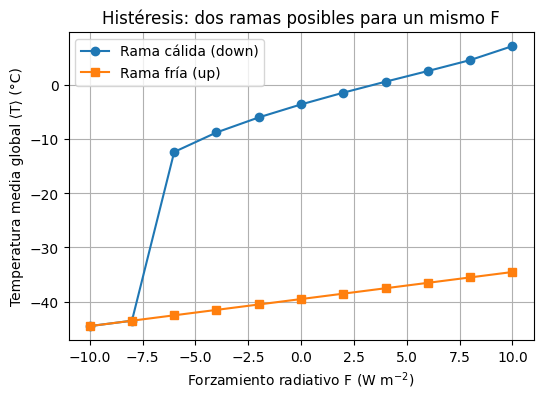

In [9]:
plt.figure(figsize=(6,4))
plt.plot(F_values_down, T_down, 'o-', label='Rama cálida (down)')
plt.plot(F_values_up,   T_up,   's-', label='Rama fría (up)')
plt.xlabel('Forzamiento radiativo F (W m$^{-2}$)')
plt.ylabel('Temperatura media global ⟨T⟩ (°C)')
plt.title('Histéresis: dos ramas posibles para un mismo F')
plt.grid(True)
plt.legend()
plt.show()


### Tareas (para tu entrega)

1. Ejecuta el notebook y obtén la figura de histéresis (rama cálida y rama fría).
2. Explica con tus palabras qué significa que, para un mismo valor de F, existan dos valores distintos de ⟨T⟩.
3. Cambia un único parámetro (elige uno):
   - `alpha_ice` (por ejemplo 0.56, 0.58, 0.60)
   - `deltaT` (por ejemplo 2.0, 2.5, 3.0)
   y describe cómo cambia la histéresis (si aparece, si desaparece, si cambia el rango).
4. Incluye al menos una figura comparativa (antes/después del cambio de parámetro).
